In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import BatchNorm1d

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    
    num_atoms = mol.GetNumAtoms()
    features = []
    for atom in mol.GetAtoms():
        feature = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetImplicitValence(),
            atom.GetIsAromatic() * 1, 
            atom.GetHybridization().real
        ]
        features.append(feature)
    
    
    x = torch.tensor(features, dtype=torch.float)
    
    
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        edge_indices.append([i, j])
        edge_indices.append([j, i])
    
    if len(edge_indices) == 0: 
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    return Data(x=x, edge_index=edge_index)


class MoleculeDataset(Dataset):
    def __init__(self, smiles_list, labels):
        super(MoleculeDataset, self).__init__()
        self.smiles_list = smiles_list
        self.labels = labels
        
        self.processed_data = []
        for i, smiles in enumerate(smiles_list):
            graph = smiles_to_graph(smiles)
            if graph is not None:
                graph.y = torch.tensor([labels[i]], dtype=torch.float)
                self.processed_data.append(graph)
    
    def len(self):
        return len(self.processed_data)
    
    def get(self, idx):
        return self.processed_data[idx]


class GNN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        
        self.lin1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = nn.Linear(hidden_channels // 2, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x.view(-1)


def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.mse_loss(output, data.y)
        loss.backward()
        optimizer.step()
        loss_all += loss.item() * data.num_graphs
    
    return loss_all / len(train_loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x, data.edge_index, data.batch)
            predictions.append(pred)
            actual.append(data.y)
    
    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actual = torch.cat(actual, dim=0).cpu().numpy()
    
    mse = mean_squared_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    return mse, r2, predictions, actual

def build_and_train_gnn_model(smiles_list, pic50_values, test_size=0.2, epochs=200):

    dataset = MoleculeDataset(smiles_list, pic50_values)
    

    train_indices, test_indices = train_test_split(
        list(range(len(dataset))), test_size=test_size, random_state=42
    )
    

    from torch_geometric.loader import DataLoader
    train_loader = DataLoader(
        [dataset[i] for i in train_indices], batch_size=16, shuffle=True
    )
    test_loader = DataLoader(
        [dataset[i] for i in test_indices], batch_size=16
    )
    
 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    

    model = GNN(num_features=6, hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    

    print('Starting training...')
    best_mse = float('inf')
    best_epoch = 0
    train_losses = []
    test_mses = []
    test_r2s = []
    
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer, device)
        test_mse, test_r2, _, _ = evaluate(model, test_loader, device)
        
        train_losses.append(train_loss)
        test_mses.append(test_mse)
        test_r2s.append(test_r2)
        
        scheduler.step(test_mse)
        
        if test_mse < best_mse:
            best_mse = test_mse
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_gnn_model.pt')
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
                  f'Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}')
    
    print(f'Best model at epoch {best_epoch} with MSE {best_mse:.4f}')
    

    model.load_state_dict(torch.load('best_gnn_model.pt'))
    

    _, _, test_pred, test_true = evaluate(model, test_loader, device)
    

    plt.figure(figsize=(10, 6))
    plt.scatter(test_true, test_pred, alpha=0.5)
    

    min_val = min(min(test_true), min(test_pred))
    max_val = max(max(test_true), max(test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Giá trị thực pIC50')
    plt.ylabel('Giá trị dự đoán pIC50')
    plt.title('So sánh giá trị thực và dự đoán từ mô hình GNN')
    plt.savefig('prediction_scatter.png')
    

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss theo epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_r2s, label='Test R²')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.title('R² Score theo epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    
    results_df = pd.DataFrame({
        'Actual_pIC50': test_true.flatten(),
        'Predicted_pIC50': test_pred.flatten()
    })
    results_df.to_csv('gnn_predictions.csv', index=False)
    return model, best_mse, test_r2s[-1]


In [48]:
df = pd.read_csv('/home/sonn/Sonn/Workspace/Projects/HelaGNN/xanthone_derivatives.csv')

In [49]:
df.head(3)

,SMILES,pIC50,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,O=c1c2cc3ccccc3cc2oc2cc(OCC3CO3)cc(OCC3CO3)c12,5.66,13.368118,13.368118,0.074935,-0.115005,0.369572,20.275862,390.391,372.247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,O=c1c2c(OCC3CS3)cc(OCC3CS3)cc2oc2ccc3ccccc3c12,4.60,13.581123,13.581123,0.054816,-0.054816,0.245122,20.275862,422.527,404.383,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1cc(OCC2CO2)cc2oc3ccccc3c(=O)c12,4.98,12.654269,12.654269,0.105763,-0.105763,0.547257,16.863636,298.294,284.182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
smiles_list = df['SMILES'].tolist()
pic50_values = df['pIC50'].tolist()

/home/sonn/anaconda3/envs/WSAIPytorch3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...
Epoch: 010, Train Loss: 0.2710, Test MSE: 0.1289, Test R²: -1.4067
Epoch: 020, Train Loss: 0.1668, Test MSE: 0.2751, Test R²: -4.1370
Epoch: 030, Train Loss: 0.1570, Test MSE: 0.1552, Test R²: -1.8983
Epoch: 040, Train Loss: 0.1529, Test MSE: 0.1281, Test R²: -1.3927
Epoch: 050, Train Loss: 0.1393, Test MSE: 0.1299, Test R²: -1.4249
Epoch: 060, Train Loss: 0.1543, Test MSE: 0.1298, Test R²: -1.4238
Epoch: 070, Train Loss: 0.1497, Test MSE: 0.1318, Test R²: -1.4618
Epoch: 080, Train Loss: 0.1588, Test MSE: 0.1233, Test R²: -1.3022
Epoch: 090, Train Loss: 0.1564, Test MSE: 0.1338, Test R²: -1.4979
Epoch: 100, Train Loss: 0.1496, Test MSE: 0.1367, Test R²: -1.5536
Epoch: 110, Train Loss: 0.1668, Test MSE: 0.1333, Test R²: -1.4899
Epoch: 120, Train Loss: 0.1529, Test MSE: 0.1318, Test R²: -1.4609
Epoch: 130, Train Loss: 0.1405, Test MSE: 0.1190, Test R²: -1.2228
Epoch: 140, Train Loss: 0.1379, Test MSE: 0.1227, Test R²: -1.2913
Epoch: 150, Train Loss: 0.1593, Test MSE:

/tmp/ipykernel_52906/2814066090.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gnn_model.pt'))


Kết quả cuối cùng: MSE = 0.0955, R² = -1.4549


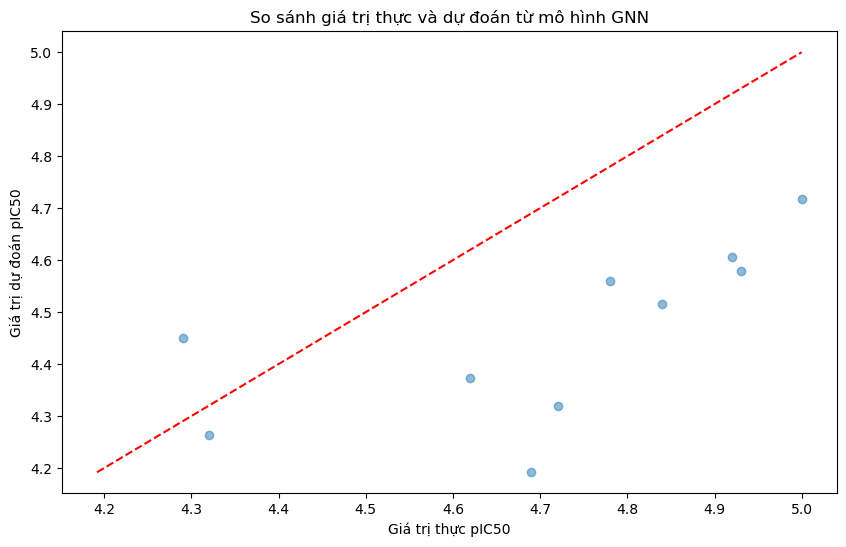

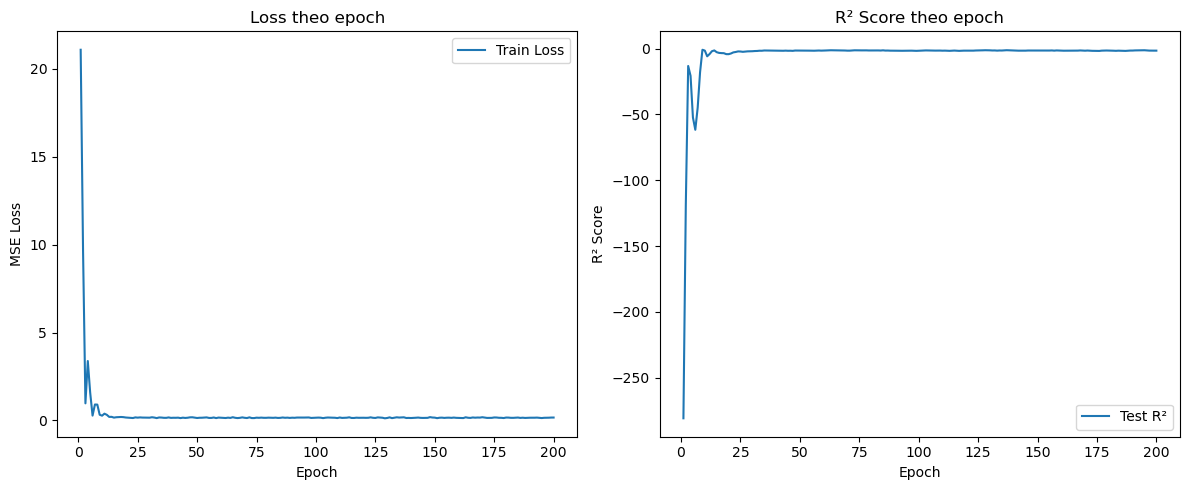

In [51]:
model, best_mse, best_r2 = build_and_train_gnn_model(smiles_list, pic50_values)
print(f'Kết quả cuối cùng: MSE = {best_mse:.4f}, R² = {best_r2:.4f}')

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import random

def augment_smiles(smiles, n_augments=5):
    """
    Tạo n_augments SMILES ngẫu nhiên cho 1 SMILES đầu vào.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    smiles_set = set()
    for _ in range(n_augments):
        new_smiles = Chem.MolToSmiles(mol, doRandom=True)
        smiles_set.add(new_smiles)

    return list(smiles_set)

def smiles_regression_augmentation(original_df, n_augments=5):
    """
    original_df: pandas DataFrame với 2 cột: 'SMILES', 'pIC50'
    """
    augmented_data = []

    for i, row in original_df.iterrows():
        original_smiles = row['SMILES']
        pic50 = row['pIC50']

        
        augmented_data.append((original_smiles, pic50))

        
        aug_smiles_list = augment_smiles(original_smiles, n_augments=n_augments)
        for aug_smiles in aug_smiles_list:
            augmented_data.append((aug_smiles, pic50))

    
    aug_df = pd.DataFrame(augmented_data, columns=['SMILES', 'pIC50'])

    return aug_df


original_df = pd.read_csv('xanthone_derivatives.csv')


augmented_df = smiles_regression_augmentation(original_df, n_augments=5)

augmented_df.to_csv('augmented_smiles_pic50.csv', index=False)
print("✅ Đã lưu file augmented_smiles_pic50.csv thành công!")

✅ Đã lưu file augmented_smiles_pic50.csv thành công!


Starting training...


/home/sonn/anaconda3/envs/WSAIPytorch3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 010, Train Loss: 0.1087, Test MSE: 0.8069, Test R²: -3.2215
Epoch: 020, Train Loss: 0.0898, Test MSE: 0.0746, Test R²: 0.6099
Epoch: 030, Train Loss: 0.0901, Test MSE: 0.0661, Test R²: 0.6544
Epoch: 040, Train Loss: 0.0693, Test MSE: 0.0538, Test R²: 0.7184
Epoch: 050, Train Loss: 0.0812, Test MSE: 0.0938, Test R²: 0.5094
Epoch: 060, Train Loss: 0.0673, Test MSE: 0.0580, Test R²: 0.6967
Epoch: 070, Train Loss: 0.0641, Test MSE: 0.0405, Test R²: 0.7882
Epoch: 080, Train Loss: 0.0650, Test MSE: 0.0395, Test R²: 0.7935
Epoch: 090, Train Loss: 0.0632, Test MSE: 0.0378, Test R²: 0.8021
Epoch: 100, Train Loss: 0.0737, Test MSE: 0.0435, Test R²: 0.7724
Epoch: 110, Train Loss: 0.0698, Test MSE: 0.0417, Test R²: 0.7818
Epoch: 120, Train Loss: 0.0572, Test MSE: 0.0416, Test R²: 0.7824
Epoch: 130, Train Loss: 0.0648, Test MSE: 0.0421, Test R²: 0.7799
Epoch: 140, Train Loss: 0.0704, Test MSE: 0.0418, Test R²: 0.7812
Epoch: 150, Train Loss: 0.0601, Test MSE: 0.0415, Test R²: 0.7830
Epoch: 16

/tmp/ipykernel_52906/2814066090.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gnn_model.pt'))


Kết quả cuối cùng: MSE = 0.0378, R² = 0.7724


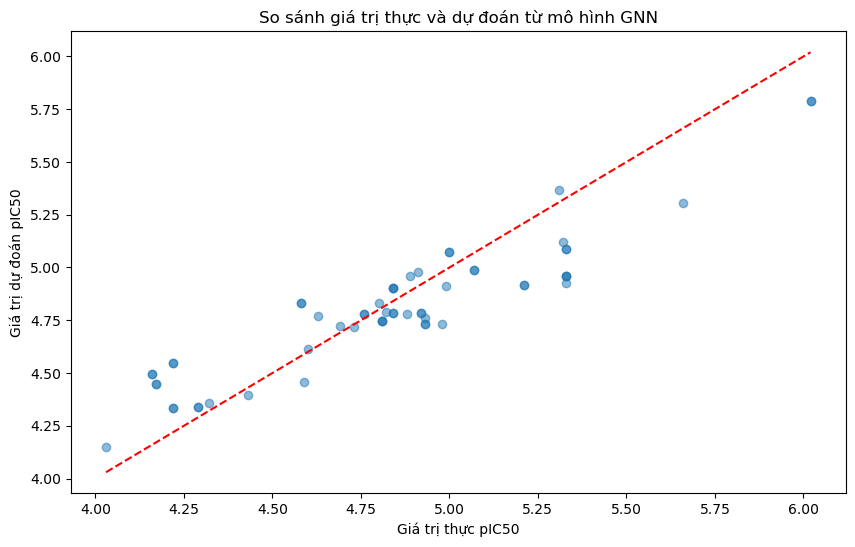

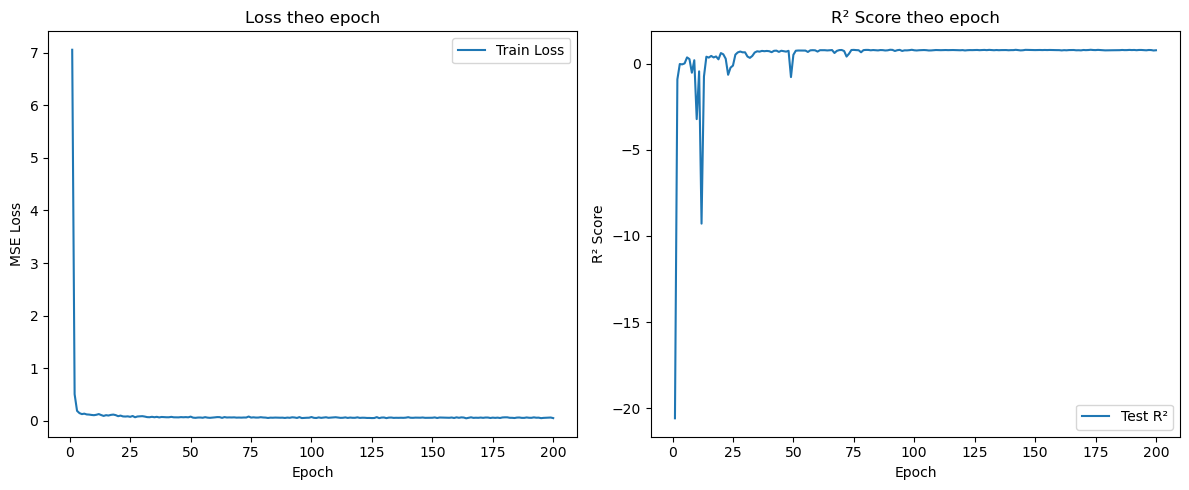

In [57]:
data_aug =  pd.read_csv("augmented_smiles_pic50.csv")
smiles_list2 = data_aug['SMILES'].tolist()
pic50_values2 = data_aug['pIC50'].tolist()
model, best_mse, best_r2 = build_and_train_gnn_model(smiles_list2, pic50_values2)
print(f'Kết quả cuối cùng: MSE = {best_mse:.4f}, R² = {best_r2:.4f}')

R² score: 0.8098


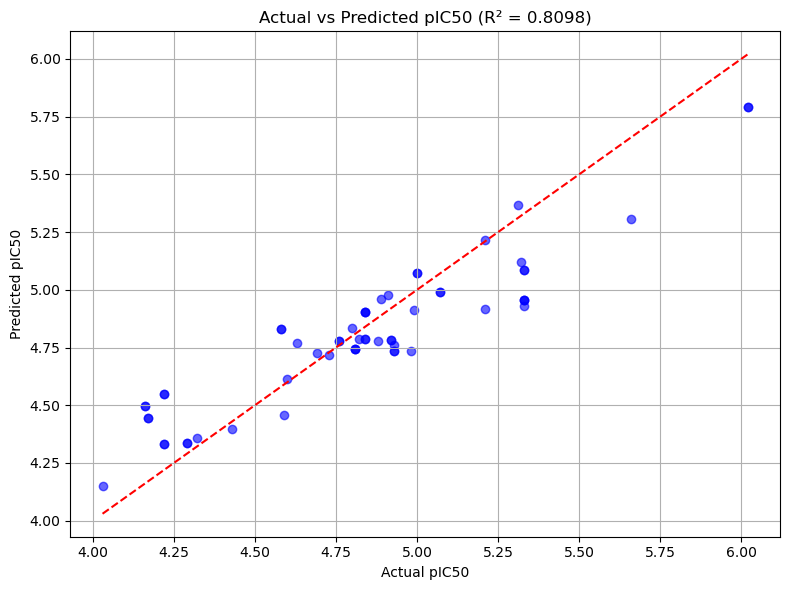

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


df = pd.read_csv('gnn_predictions.csv')


y_true = df['Actual_pIC50'].values
y_pred = df['Predicted_pIC50'].values

r2 = r2_score(y_true, y_pred)
print(f'R² score: {r2:.4f}')


plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Đường y = x
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title(f'Actual vs Predicted pIC50 (R² = {r2:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
from sklearn.metrics import root_mean_squared_error

In [66]:
root_mean_squared_error(y_true, y_pred)

0.1906823311367569